In [1]:
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsforecast.models import Theta
from statsforecast import StatsForecast
import pandas as pd
import numpy as np
import pandas as pd
import argparse
import random
import time
import os
import duckdb
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from crptmidfreq.config_loc import *
from crptmidfreq.featurelib.lib_v1 import *
from crptmidfreq.strats import *
from crptmidfreq.utils.common import to_csv
from crptmidfreq.utils.univ import hardcoded_universe_1
plt.style.use('ggplot')


g_folder = 'res_exploration_v2'
g_reg = StepperRegistry()
clean_folder(g_folder)

cfg={}
defargs = {'folder':g_folder,'name':None,'r':g_reg,'cfg':cfg}
defargs2 = {'folder':g_folder,'name':None,'r':g_reg}

/Users/sachadrevet/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sachadrevet/anaconda3/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/sachadrevet/anaconda3/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
2025-04-17 14:11:02 - Cleaning folder res_exploration_v2



Holt Winter is interesting:
- beta=infinity or 0.0  is same as ewm
- beta=100 here gives a reasonable output with trends
- when beta is too small ( but > 0) the result oscillates too much

Gamma is supposed to be for seasonality adjustments. We tried it on volumes
- theta =  infinity of 0.0 does nothing
- theta = 100 here makes something less smooth than the ewm with alpha already. 

In [2]:

featd=prepare_klines(start_date='2024-09-01',
                   end_date='2026-01-01',
                   tokens=['BNBUSDT'],
                   **defargs)
featd['turnover_log']=np.log(featd['turnover']+1e-6)+10.0
featd,f1=perform_ewm(featd,feats=['close'],windows=[200],**defargs2)
featd,f2=perform_holt_winter(featd, feats=['close'], alphas=[200],
                             # beta=0 is infinity actually  ==> same as ewm
                             # beta low ( but >0 ) will show oscillations
                             betas=[0.0,50,200], 
                             gammas=[10.0],use_seasonality=False,
                             **defargs2)
featd,f4=perform_ewm(featd,feats=['turnover_log'],windows=[10],**defargs2)
featd,f3=perform_holt_winter(featd, 
                             feats=['turnover_log'], 
                             alphas=[100],
                             betas=[100],
                             time_unit=1e9*60,
                             mems=[24*60], # 1 day seasonality
                             # gamma=0 and infinity are the same ==> same as ewm
                             gammas=[0.0,100,1000],
                             use_seasonality=True,**defargs2)
df=pd.DataFrame({k:featd[k] for k in featd.keys()})
df['dts']=pd.to_datetime(df['dtsi']*1e3)
df=df.set_index('dts')

2025-04-17 14:11:03 - Missing key=use_lazy_dict in cfg for kmeans_sret -- will use default value
2025-04-17 14:11:03 - Missing key=window_volume_wgt in cfg for kmeans_sret -- will use default value
2025-04-17 14:11:03 - prepare_klines start_date=2024-09-01 end_date=2026-01-01
2025-04-17 14:11:03 - Reading data from DuckDB
2025-04-17 14:11:08 - Stepper creating instance res_exploration_v2 None_cnt_exists
2025-04-17 14:11:12 - Stepper creating instance res_exploration_v2 None_close_diff1
2025-04-17 14:11:13 - Stepper creating instance res_exploration_v2 None_tret_clip
2025-04-17 14:11:13 - Stepper creating instance res_exploration_v2 None_turnover_ewm43200
2025-04-17 14:11:14 - Stepper creating instance res_exploration_v2 None_turnover_ewm43200_qtl
2025-04-17 14:11:15 - Stepper creating instance res_exploration_v2 None_close_ewm200
2025-04-17 14:11:15 - Stepper creating instance res_exploration_v2 None_close_200x0.0x10.0x100_False
2025-04-17 14:11:17 - Stepper creating instance res_explo

Saved : /Users/sachadrevet/data_tmp/analysis/ee.csv


<Axes: xlabel='dts'>

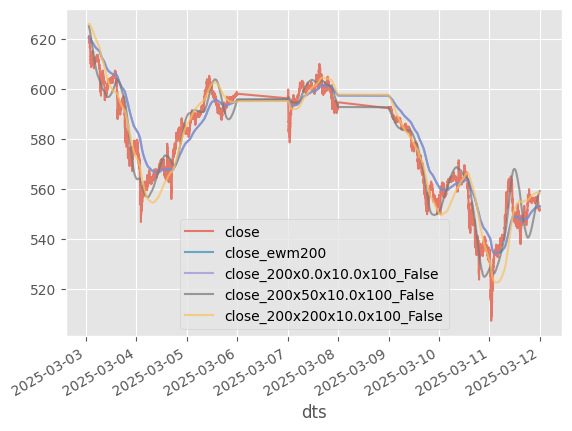

In [3]:
ndf=df[['close']+f1+f2].iloc[1000:].tail(10_000)
to_csv(ndf,'ee')
ndf.plot(alpha=0.7)

In [4]:
df[['close']+f1+f2].diff().corr()[['close_ewm200']]

,close_ewm200
close,0.083394
close_ewm200,1.000000
close_200x0.0x10.0x100_False,0.999506
close_200x50x10.0x100_False,0.747173
close_200x200x10.0x100_False,0.942674


Saved : /Users/sachadrevet/data_tmp/analysis/ee_seasonal.csv


<Axes: xlabel='dts'>

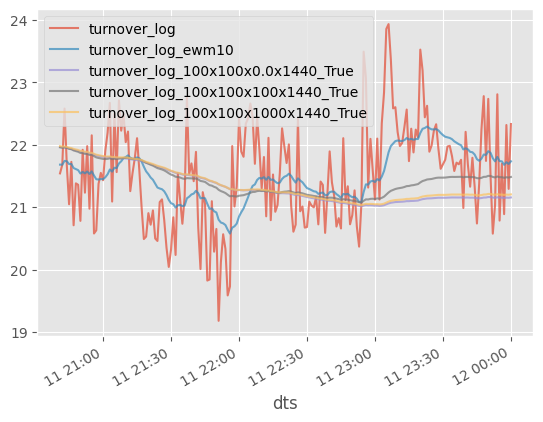

In [5]:
ndf=df[['turnover_log']+f4+f3].iloc[1000:]
to_csv(ndf.tail(100_000),'ee_seasonal')
ndf.tail(200).plot(alpha=0.7)

<Axes: xlabel='hour'>

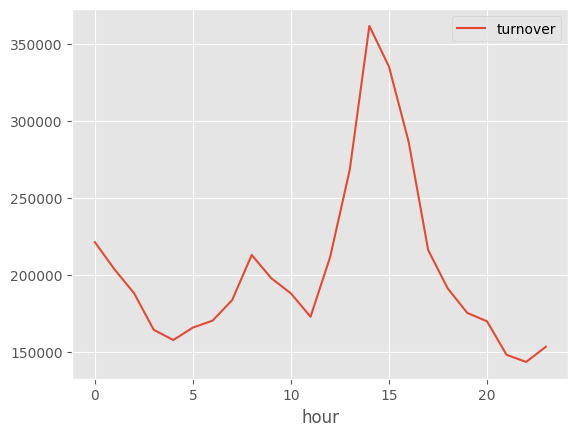

In [6]:
df['dts']=df.index
df['time']=df['dts'].astype(np.int64)/1e9
df['time']=df['time']%(3600*24)
df['hour']=df['time']//3600

volume_profile=df.groupby('hour')[['turnover']].median()
volume_profile.plot()

In [7]:
ndf.describe()

,turnover_log,turnover_log_ewm10,turnover_log_100x100x0.0x1440_True,turnover_log_100x100x100x1440_True,turnover_log_100x100x1000x1440_True
count,239480.000000,239480.000000,239480.000000,239480.000000,239480.000000
mean,22.233103,22.233114,22.233578,22.232841,22.233435
std,1.222147,0.940843,0.872690,0.850319,0.865602
min,-3.815511,-3.662263,8.761606,4.071846,8.206830
25%,21.512878,21.666293,21.677856,21.703137,21.682988
50%,22.199985,22.206357,22.216792,22.214366,22.218585
75%,22.936488,22.782398,22.759348,22.748778,22.755843
max,27.606279,25.944588,25.925287,25.713729,25.881777


In [8]:
df[f4+f3].diff().corr()

,turnover_log_ewm10,turnover_log_100x100x0.0x1440_True,turnover_log_100x100x100x1440_True,turnover_log_100x100x1000x1440_True
turnover_log_ewm10,1.000000,0.722387,0.640864,0.732532
turnover_log_100x100x0.0x1440_True,0.722387,1.000000,0.682322,0.973343
turnover_log_100x100x100x1440_True,0.640864,0.682322,1.000000,0.825324
turnover_log_100x100x1000x1440_True,0.732532,0.973343,0.825324,1.000000


In [9]:
24*60

1440